In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
from pathlib import Path
import re

main_folder = Path('.')

# Make an empty list to store dataframes
all_dataframes = []

# Loop through all subfolders within the main folder
for subfolder in main_folder.iterdir():         # Loading in each file name and making it *pretty*
    if subfolder.is_dir():
        if 'Part_B' in subfolder.name:
            part_type = 'Part_B'
            file_name_slice = slice(5, -11)
        elif 'Part_A' in subfolder.name:
            part_type = 'Part_A'
            file_name_slice = slice(7, -14)
        else:
            continue  # Skip any folders not labeled Part_A or Part_B (this was when I had a junk folder, but I got rid of it)

        # Loop through all CSV files within the subfolder
        for csv_file in subfolder.glob('*.csv'):
            try:
                df = pd.read_csv(csv_file, encoding='ISO-8859-1', skiprows=44, usecols=[0, 1], names=['Frequency', 'Amplitude'])
            except Exception as e:
                print(f"Error reading {csv_file}: {e}")  # Skip to the next file if there's an error
                continue

            # Add metadata columns for reference later
            df['source_folder'] = subfolder.name
            df['source_folder_label'] = subfolder.name.replace('_', ' ')
            df['source_file'] = csv_file.stem[file_name_slice]  # Use part-specific slice
            df['source_file_label'] = csv_file.stem[file_name_slice].replace('_', ' ')
            df['part_type'] = part_type  # New column to distinguish Part_A from Part_B

            # Append the dataframe to the list
            all_dataframes.append(df)

# Concatenate all the dataframes into one dataframe
combined_df = pd.concat(all_dataframes, ignore_index=True)

# Display combined dataframe to check structure
print(combined_df)

        Frequency  Amplitude   source_folder source_folder_label  \
0       490000000 -79.569894          Part_A              Part A   
1       490020000 -79.117935          Part_A              Part A   
2       490040000 -79.132885          Part_A              Part A   
3       490060000 -79.002551          Part_A              Part A   
4       490080000 -78.358500          Part_A              Part A   
...           ...        ...             ...                 ...   
38031  2569920000 -94.382634  Part_B_RMS_PWR      Part B RMS PWR   
38032  2569940000 -94.473433  Part_B_RMS_PWR      Part B RMS PWR   
38033  2569960000 -94.168152  Part_B_RMS_PWR      Part B RMS PWR   
38034  2569980000 -94.319008  Part_B_RMS_PWR      Part B RMS PWR   
38035  2570000000 -94.384161  Part_B_RMS_PWR      Part B RMS PWR   

                  source_file       source_file_label part_type  
0           25dBm_1000kHz_RBW       25dBm 1000kHz RBW    Part_A  
1           25dBm_1000kHz_RBW       25dBm 1000kHz R

# Part A: Determining the relationship between RBW and noise floor

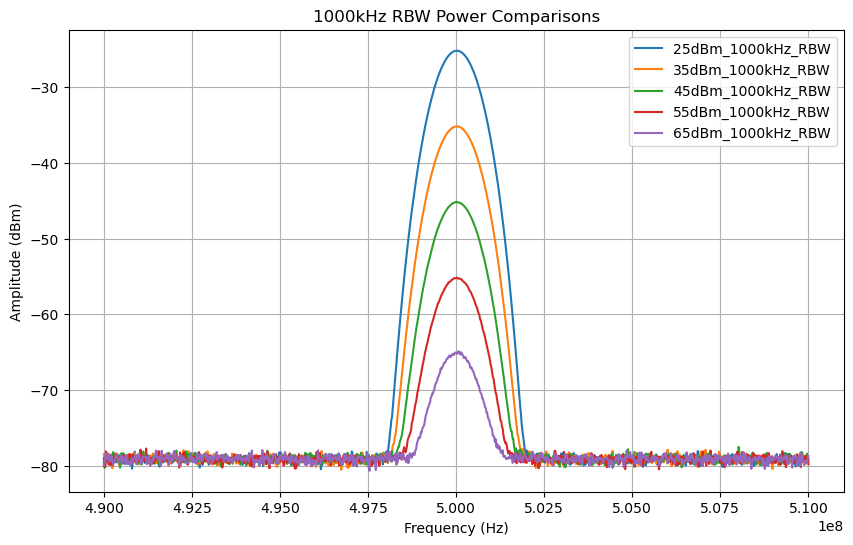

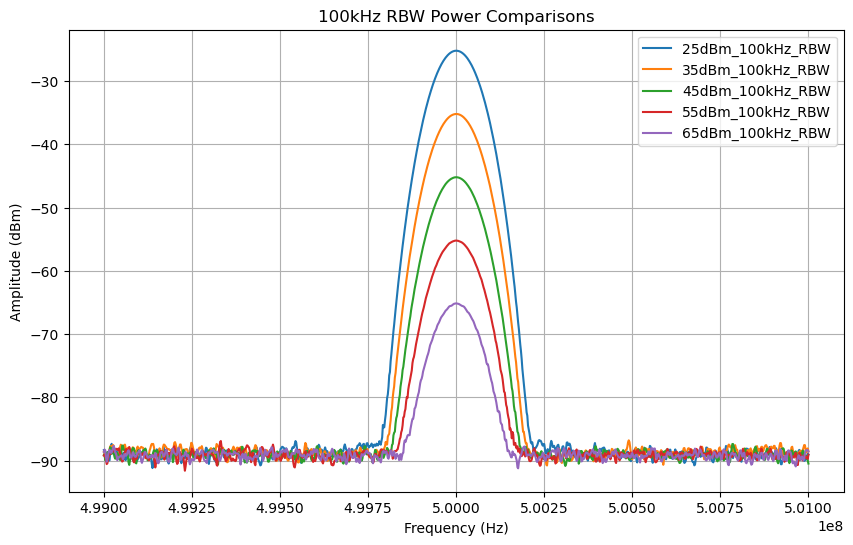

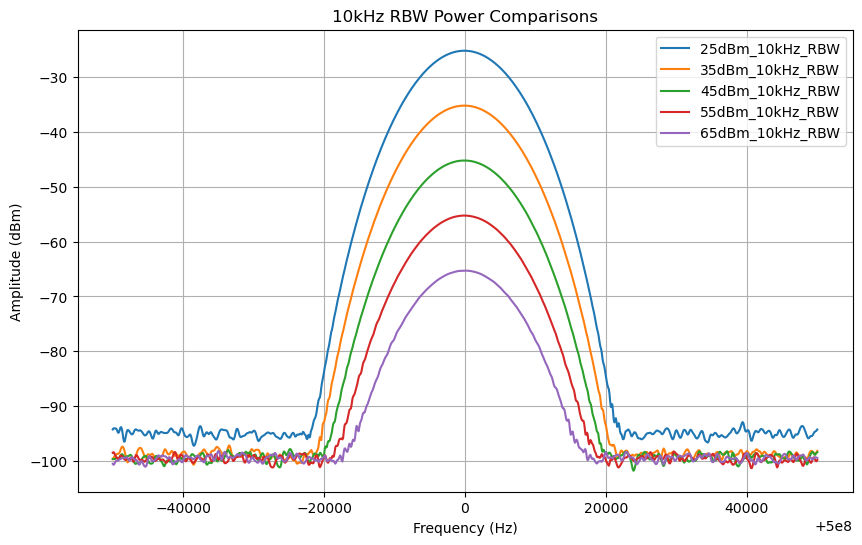

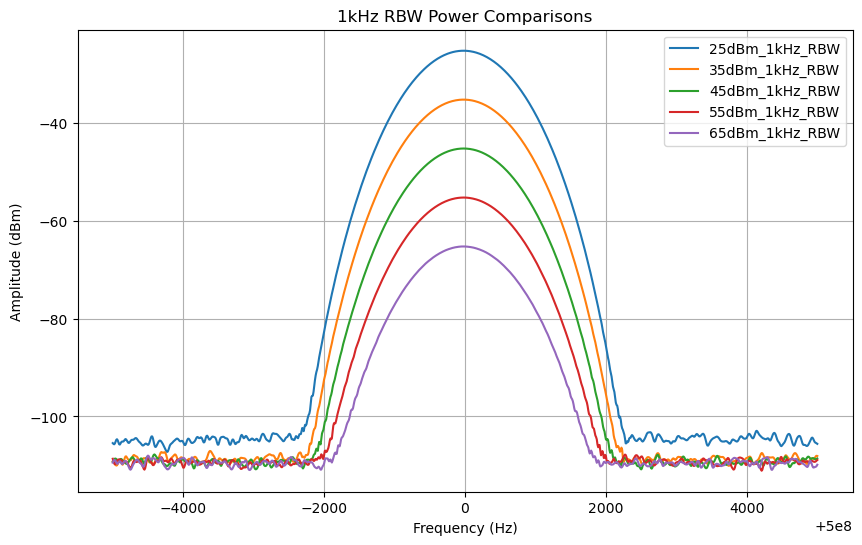

In [40]:
# Define the function to extract numeric value from the filename for sorting
def extract_numeric(filename):
    match = re.search(r'(\d+)', filename)  # Find the first sequence of digits
    return int(match.group(0)) if match else float('inf')  # Return a large number if no digits found

# Filter combined_df for Part_A only
part_a_df = combined_df[combined_df['part_type'] == 'Part_A']

# Group by the source_folder
for folder_name, folder_df in part_a_df.groupby('source_folder'):
    
    # Extract unique stems
    unique_stems = folder_df['source_file'].apply(lambda x: re.search(r'(\d+kHz_RBW)', x))
    unique_stems = unique_stems.dropna().apply(lambda x: x.group(0)).unique()
    
    for stem in unique_stems:
        plt.figure(figsize=(10, 6))  # Set the figure size within the loop for each plot

        stem_files = folder_df[folder_df['source_file'].str.contains(str(stem))]

        # Get unique file names within this stem group and sort them
        unique_files = stem_files['source_file'].unique()
        sorted_files = sorted(unique_files, key=extract_numeric)
        title = stem
        # Plot each unique file within the stem group on the same figure
        for file_name in sorted_files:
            file_df = stem_files[stem_files['source_file'] == file_name]
            plt.plot(file_df['Frequency'], file_df['Amplitude'], label=f"{file_name}")
        
        # Set the x-axis to display a controlled number of ticks
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude (dBm)')
        plt.title(f'{title.replace("_", " ")} Power Comparisons')
        plt.legend()
        #plt.legend(title='File', bbox_to_anchor=(1.05, 1), loc='upper left')
        #plt.subplots_adjust(right=0.75)
        plt.grid(True)
        plt.show()

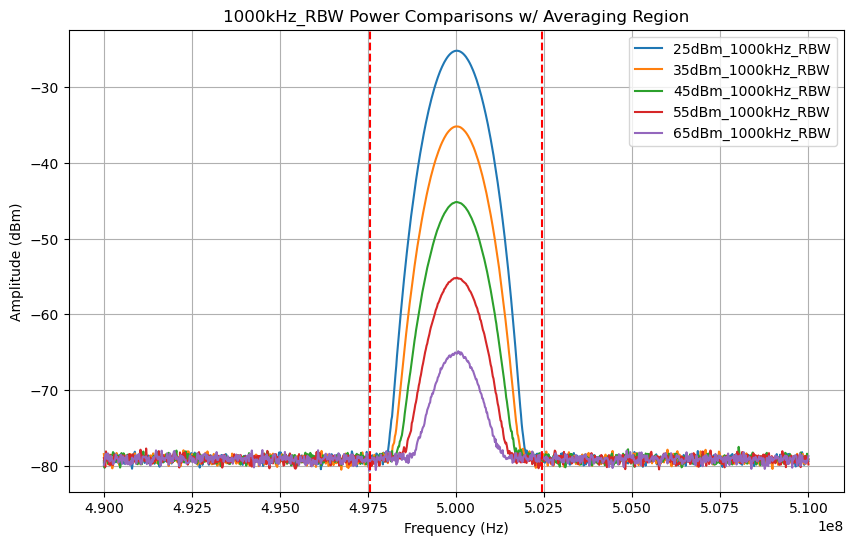

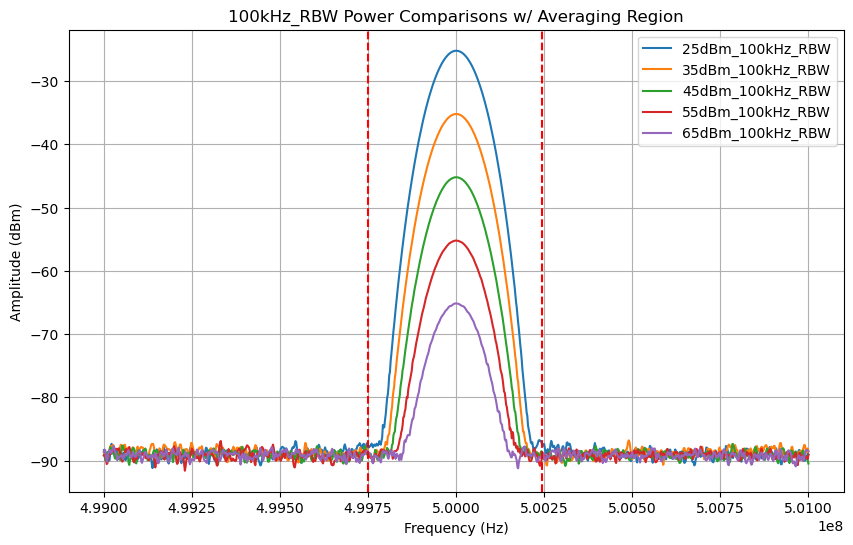

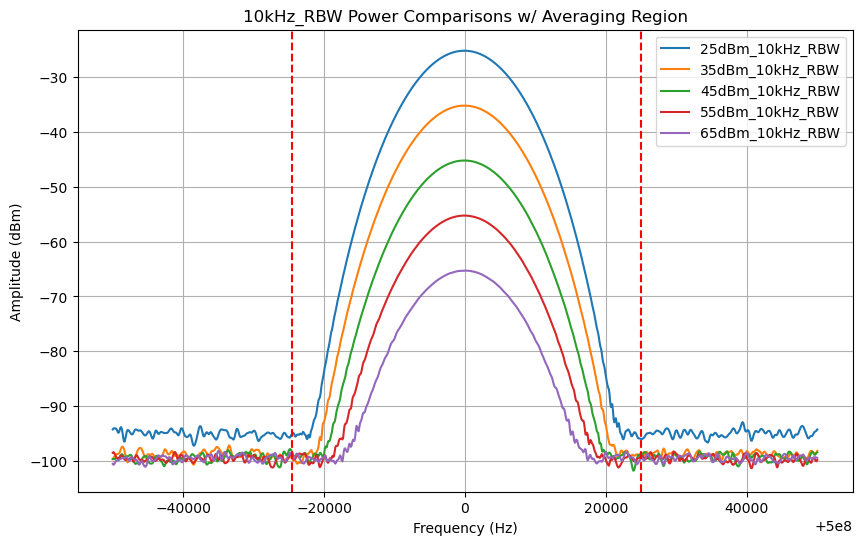

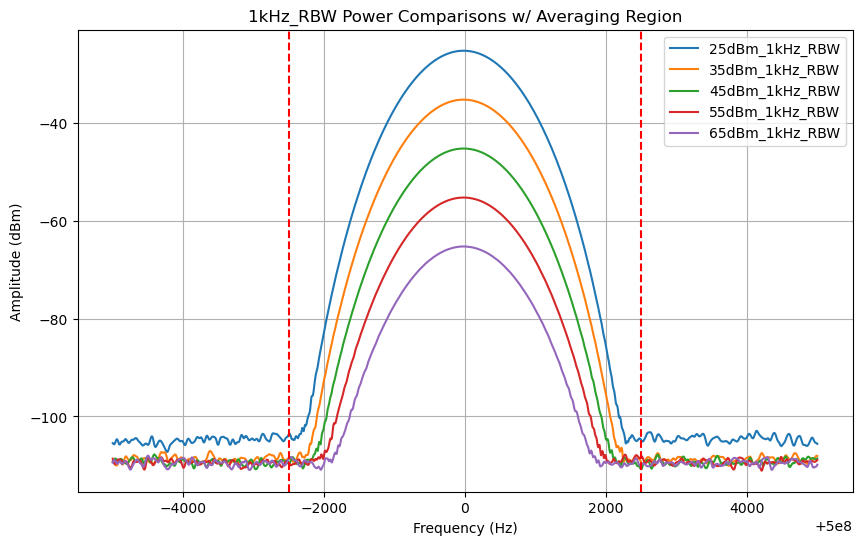

In [ ]:
# Define the clipping frequency ranges based on stems
frequency_clipping_ranges = {
    '1kHz_RBW': (-2500+5e8,2500+5e8),
    '10kHz_RBW': (-24500+5e8, 25000+5e8),
    '100kHz_RBW': (245000+5e8, -250000+5e8),
    '1000kHz_RBW': (-2450000+5e8, 2450000+5e8),}

# Filter combined_df for Part_A only
part_a_df = combined_df[combined_df['part_type'] == 'Part_A']

# Group by the source_folder
for folder_name, folder_df in part_a_df.groupby('source_folder'):
    
    # Extract unique stems
    unique_stems = folder_df['source_file'].apply(lambda x: re.search(r'(\d+kHz_RBW)', x))
    unique_stems = unique_stems.dropna().apply(lambda x: x.group(0)).unique()
    
    for stem in unique_stems:
        plt.figure(figsize=(10, 6))
        
        stem_files = folder_df[folder_df['source_file'].str.contains(str(stem))]

        # Get unique file names within this stem group and sort them
        unique_files = stem_files['source_file'].unique()
        sorted_files = sorted(unique_files, key=extract_numeric)
        
        # Plot each unique file within the stem group on the same figure
        for file_name in sorted_files:
            file_df = stem_files[stem_files['source_file'] == file_name]
            plt.plot(file_df['Frequency'], file_df['Amplitude'], label=f"{file_name}")
        
        # Draw red vertical lines indicating the clipping boundaries
        if stem in frequency_clipping_ranges:
            freq_min, freq_max = frequency_clipping_ranges[stem]
            plt.axvline(x=freq_min, color='red', linestyle='--', label='_nolegend_')
            plt.axvline(x=freq_max, color='red', linestyle='--', label='_nolegend_')

        # Set the x-axis to display a controlled number of ticks
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude (dBm)')
        plt.title(f'{stem} Power Comparisons w/ Averaging Region')
        plt.legend()
        plt.grid(True)
        plt.show()

# Part B: Determining the insertion loss of an RF cable

In [29]:
# Define the clipping frequency ranges based on stems
frequency_clipping_ranges = {
    '1kHz_RBW': (5e8 - 2500, 5e8 + 2500),
    '10kHz_RBW': (5e8 - 24500, 5e8 + 25000),
    '100kHz_RBW': (5e8 - 245000, 5e8 + 250000),
    '1000kHz_RBW': (5e8 - 2450000, 5e8 + 2450000),
}

# Filter combined_df for Part_A only
part_a_df = combined_df[combined_df['part_type'] == 'Part_A']

# Extract unique stems based on the pattern (number)kHzRBW
unique_stems = part_a_df['source_file'].apply(lambda x: re.search(r'(\d+kHz_RBW)', x))
unique_stems = unique_stems.dropna().apply(lambda x: x.group(0)).unique()

# Group files based on stems and apply clipping
for stem in unique_stems:
    print(f"\nStem: {stem}")
    
    # Get the clipping range for the current stem
    if stem in frequency_clipping_ranges:
        freq_min, freq_max = frequency_clipping_ranges[stem]
        
        # Filter files that match the current stem
        stem_files = part_a_df[part_a_df['source_file'].str.contains(str(stem))]
        
        # Get unique file names within this stem group
        unique_files = stem_files['source_file'].unique()
        
        for file_name in unique_files:
            # Filter data for the current file
            file_df = stem_files[stem_files['source_file'] == file_name]
            
            # Exclude data within the clipping range (outside the range)
            outside_clip = file_df[(file_df['Frequency'] < freq_min) | (file_df['Frequency'] > freq_max)]
            
            # Get data inside the clipping range (within the range)
            inside_clip = file_df[(file_df['Frequency'] >= freq_min) & (file_df['Frequency'] <= freq_max)]
            
            # Calculate the average amplitude outside the clipping range
            average_amplitude_outside_clip = outside_clip['Amplitude'].mean()
            
            # Find the maximum amplitude within the clipping range
            max_amplitude_within_clip = inside_clip['Amplitude'].max()
            
            # Calculate the SNR (dB) as 20 * log10(max_amplitude / average_amplitude)
            if average_amplitude_outside_clip != 0:
                snr_dB = max_amplitude_within_clip - average_amplitude_outside_clip
            else:
                snr_dB = float('inf')  # If noise is zero, SNR is infinite
            
            print(f"  File: {file_name}")
            print(f"    Average Noise Amplitude outside range: {average_amplitude_outside_clip:.2f} dBm")
            print(f"    Maximum Signal Amplitude within range: {max_amplitude_within_clip:.2f} dBm")
            print(f"    SNR: {snr_dB:.2f} dB")


Stem: 1000kHz_RBW
  File: 25dBm_1000kHz_RBW
    Average Noise Amplitude outside range: -79.12 dBm
    Maximum Signal Amplitude within range: -25.20 dBm
    SNR: 53.92 dB
  File: 35dBm_1000kHz_RBW
    Average Noise Amplitude outside range: -79.13 dBm
    Maximum Signal Amplitude within range: -35.19 dBm
    SNR: 43.94 dB
  File: 45dBm_1000kHz_RBW
    Average Noise Amplitude outside range: -79.09 dBm
    Maximum Signal Amplitude within range: -45.16 dBm
    SNR: 33.92 dB
  File: 55dBm_1000kHz_RBW
    Average Noise Amplitude outside range: -79.12 dBm
    Maximum Signal Amplitude within range: -55.15 dBm
    SNR: 23.96 dB
  File: 65dBm_1000kHz_RBW
    Average Noise Amplitude outside range: -79.11 dBm
    Maximum Signal Amplitude within range: -64.87 dBm
    SNR: 14.24 dB

Stem: 100kHz_RBW
  File: 25dBm_100kHz_RBW
    Average Noise Amplitude outside range: -88.94 dBm
    Maximum Signal Amplitude within range: -25.22 dBm
    SNR: 63.72 dB
  File: 35dBm_100kHz_RBW
    Average Noise Amplitude

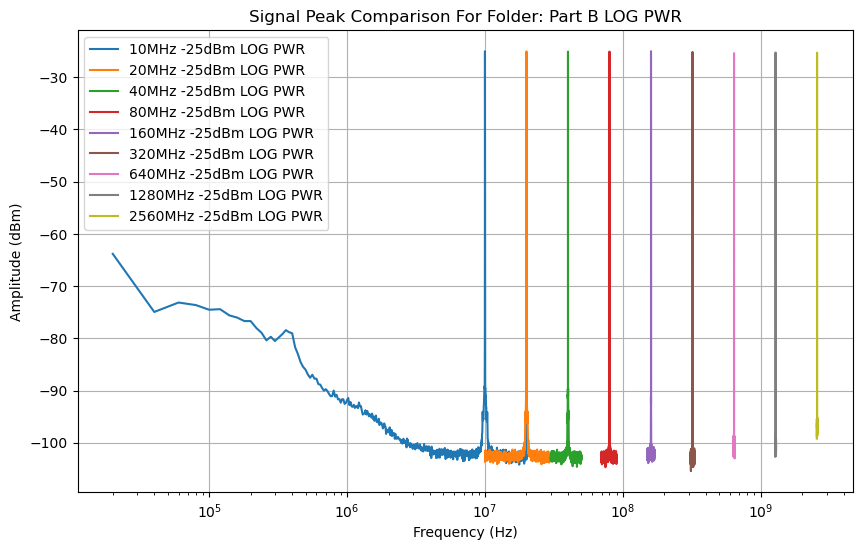

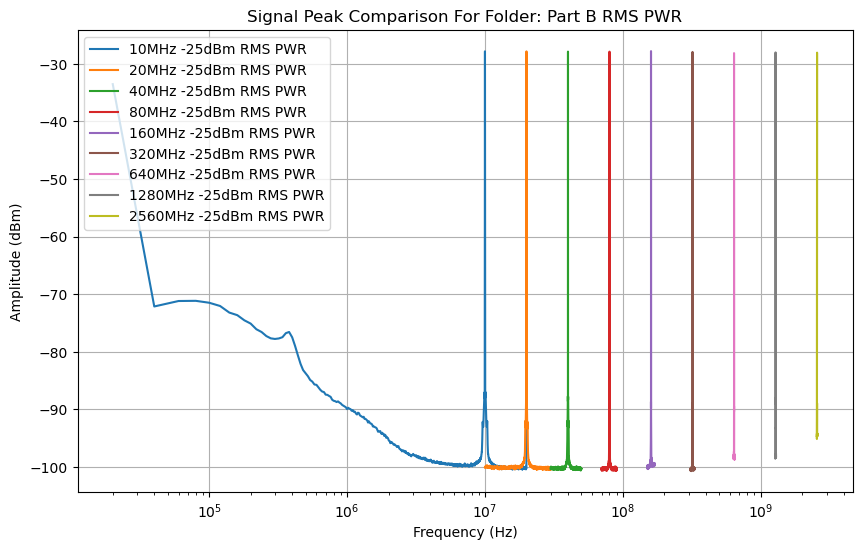

In [42]:
# Filter combined_df for Part_B only
part_b_df = combined_df[combined_df['part_type'] == 'Part_B']

# Group by the source_folder
for folder_name, folder_df in part_b_df.groupby('source_folder'):
    plt.figure(figsize=(10, 6))
    
    # Get unique file names and sort them numerically based on frequency
    unique_files = folder_df['source_file'].unique()
    
    # Function to extract numeric value for sorting
    def extract_numeric(filename):
        match = re.search(r'(\d+)', filename)  # Find the first sequence of digits
        return int(match.group(0)) if match else float('inf')  # Return a large number if no digits found

    # Sort files using the extract_numeric function
    sorted_files = sorted(unique_files, key=extract_numeric)

    # Plot each unique file within the folder on the same figure
    for file_name in sorted_files:
        file_df = folder_df[folder_df['source_file'] == file_name]
        
        # Assume the first column is frequency and the second is amplitude
        plt.plot(file_df['Frequency'], file_df['Amplitude'], label=file_name.replace("_", " "))
        
    # Set logarithmic scale for the x-axis
    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dBm)')
    title = folder_name
    plt.title(f'Signal Peak Comparison For Folder: {title.replace("_", " ")}')
    plt.legend()
    plt.grid(True)
    plt.show()

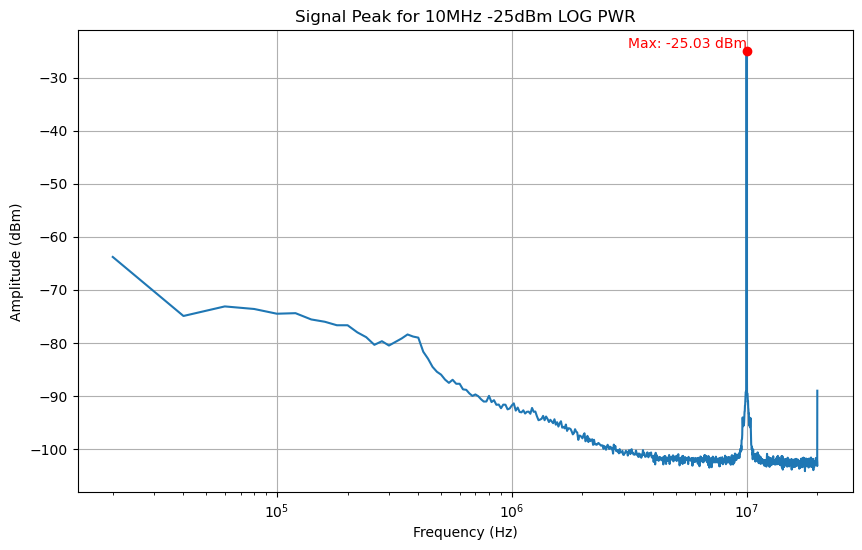

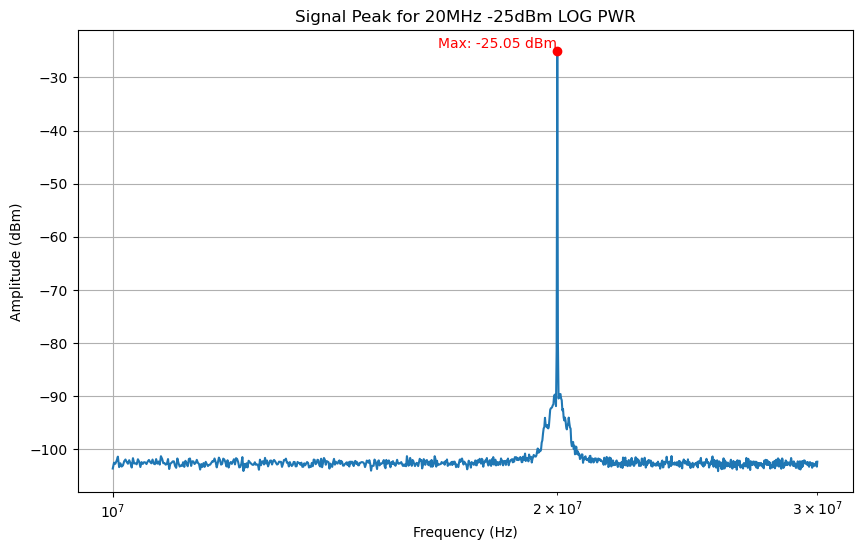

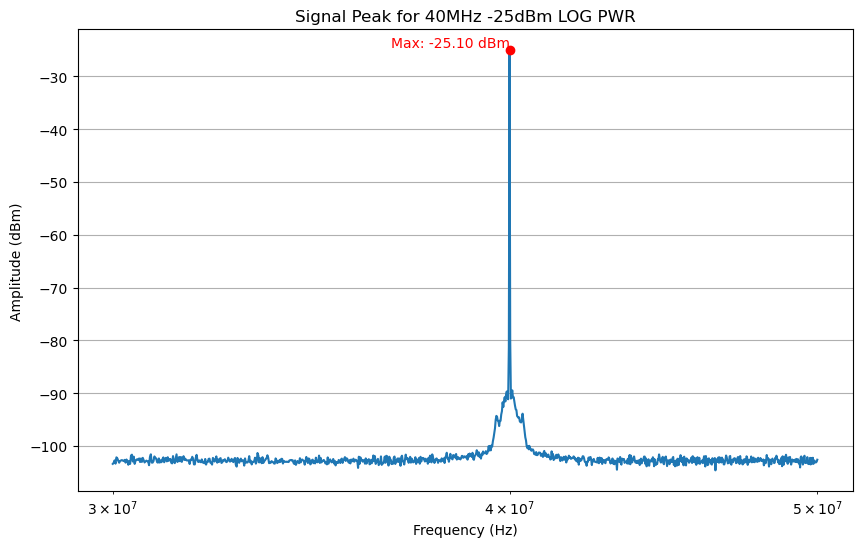

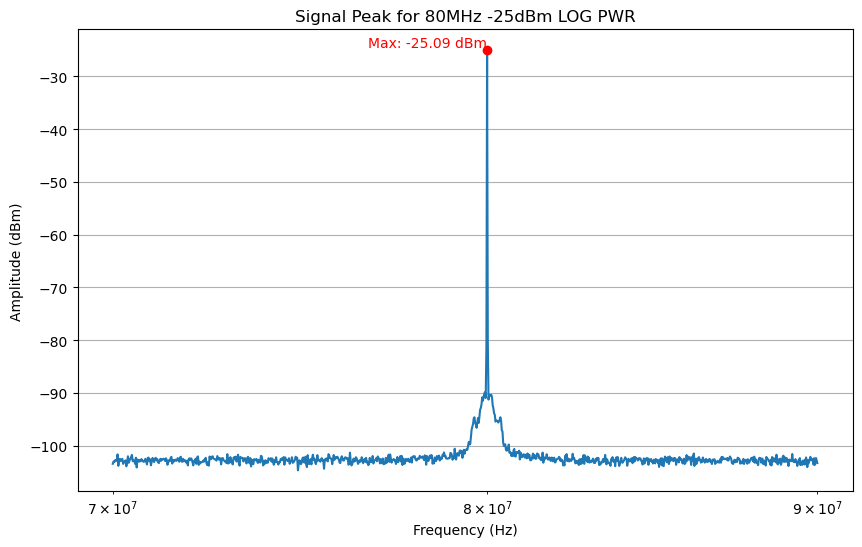

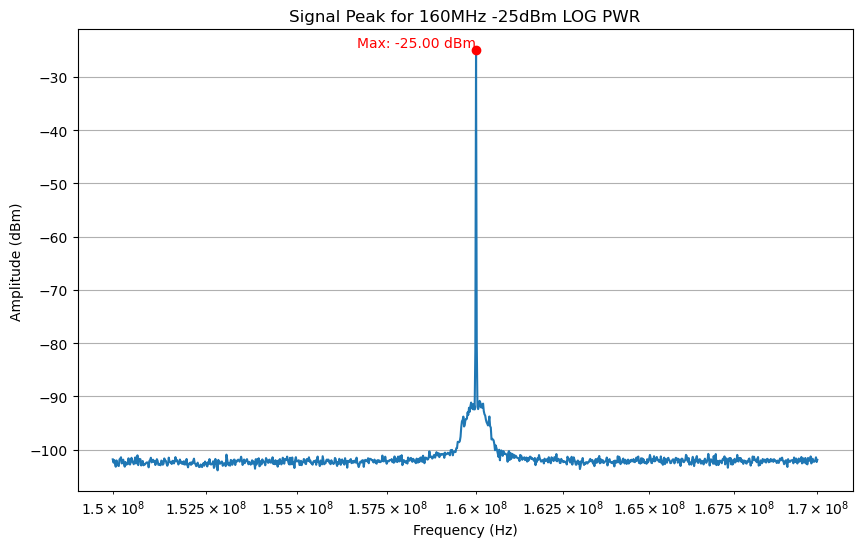

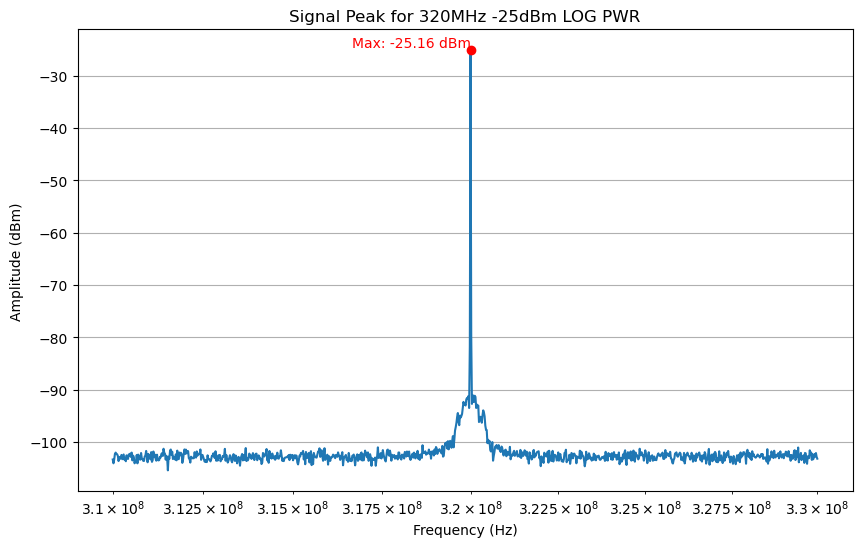

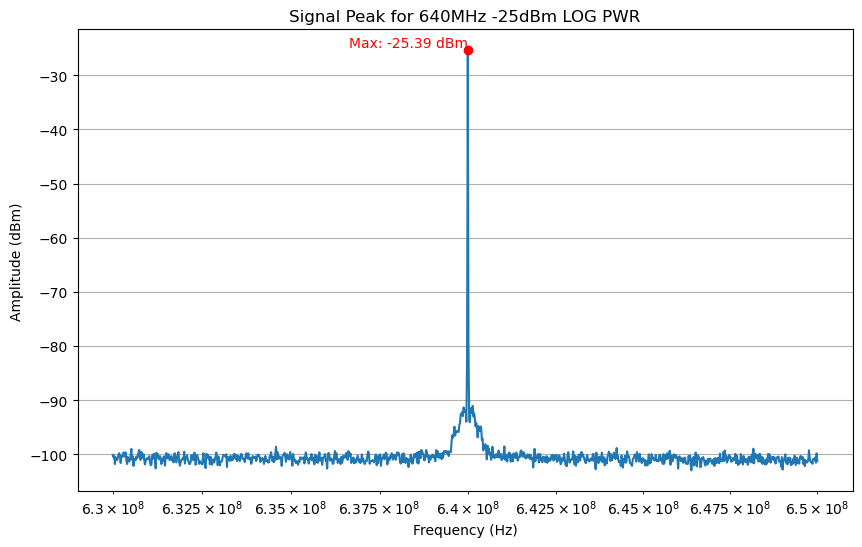

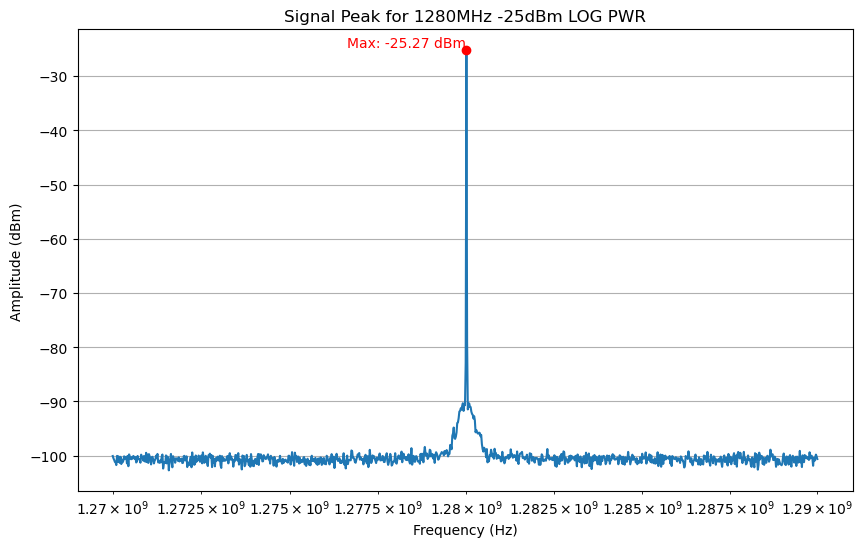

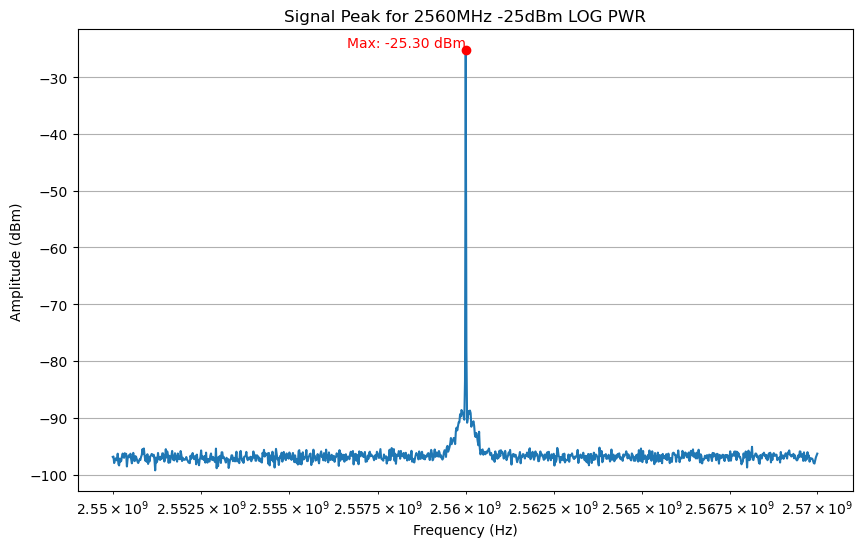

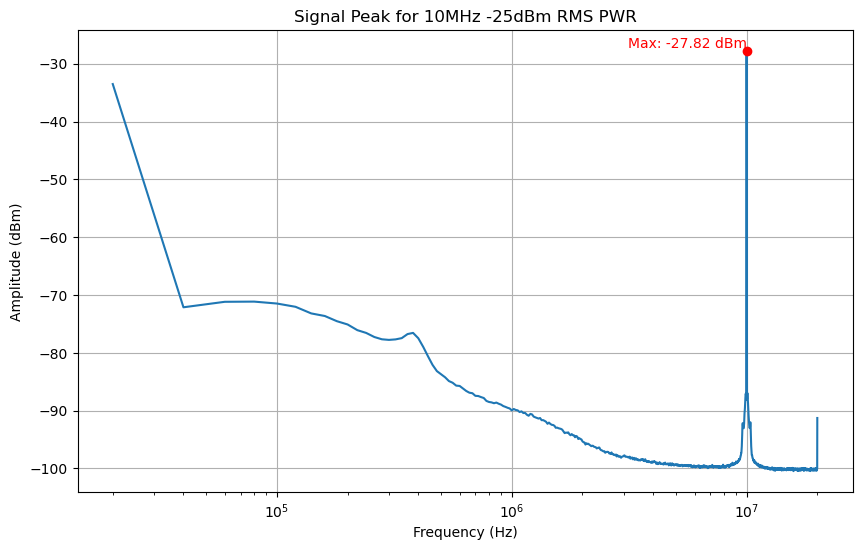

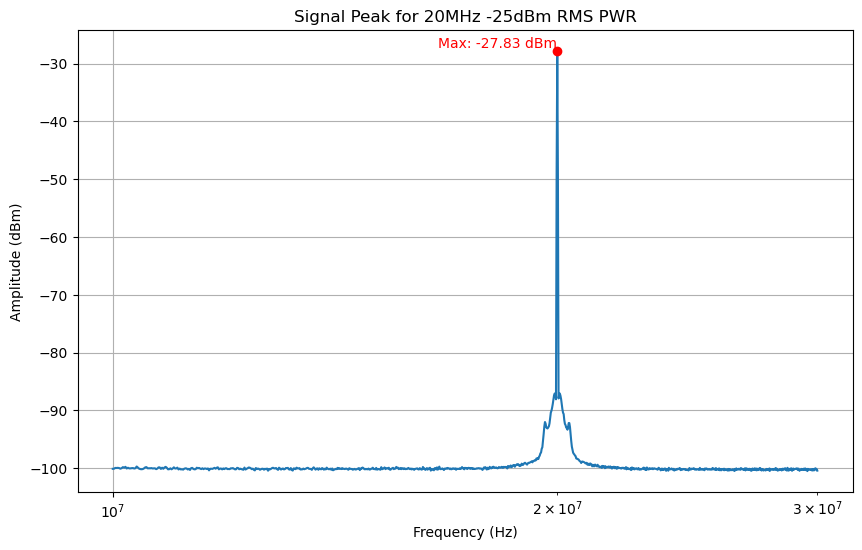

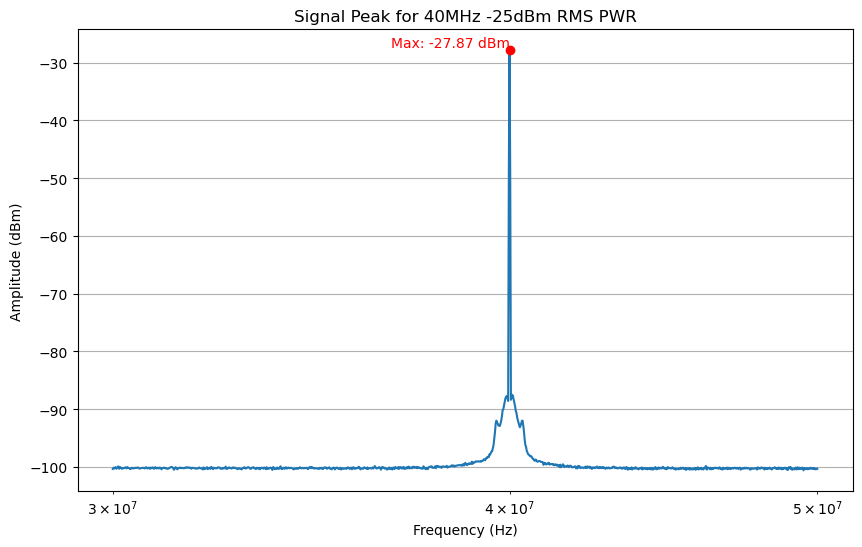

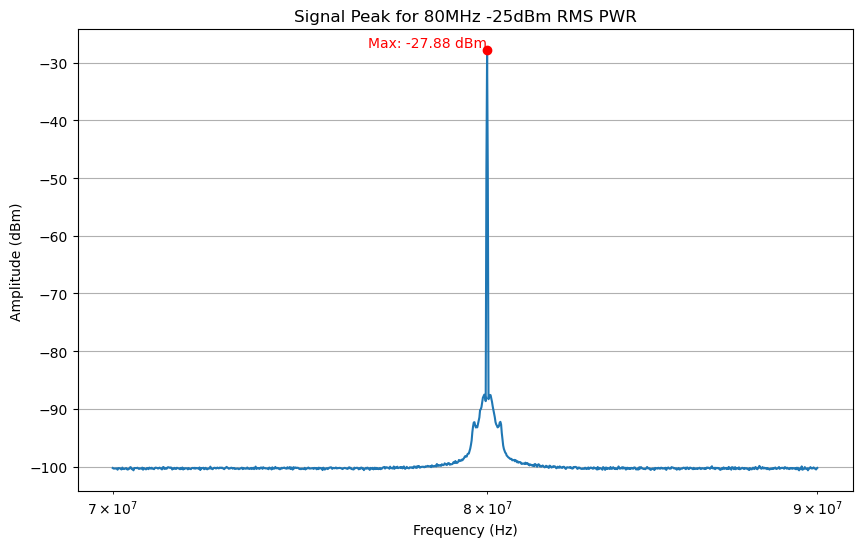

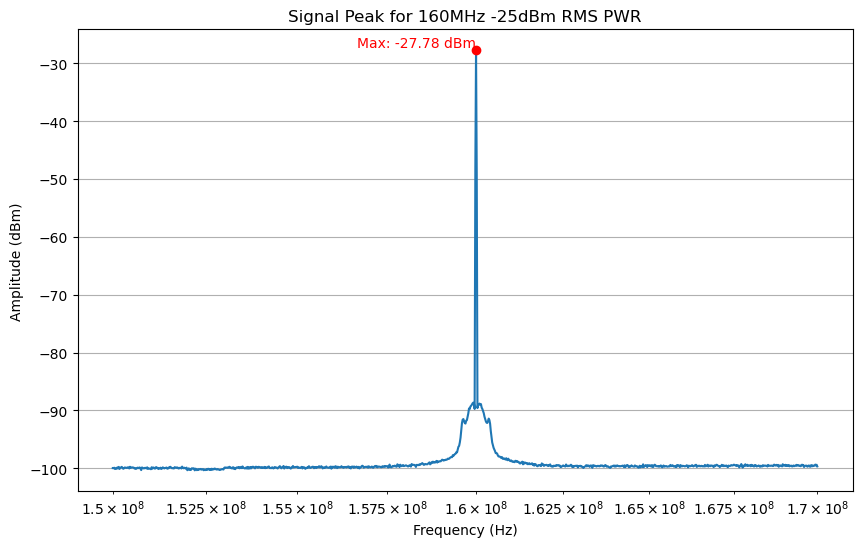

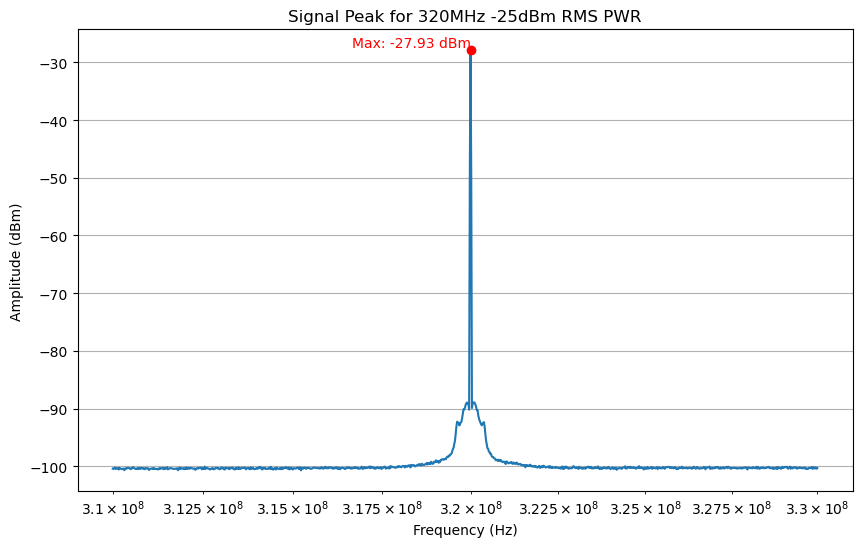

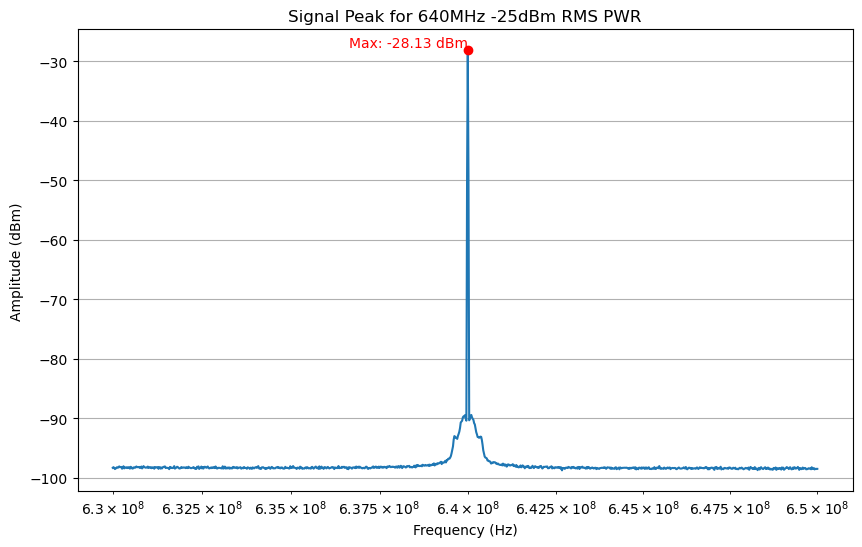

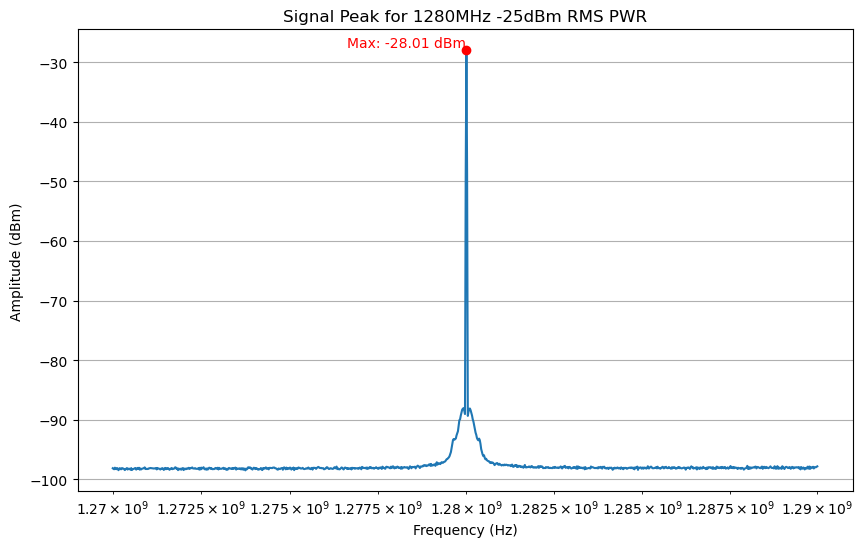

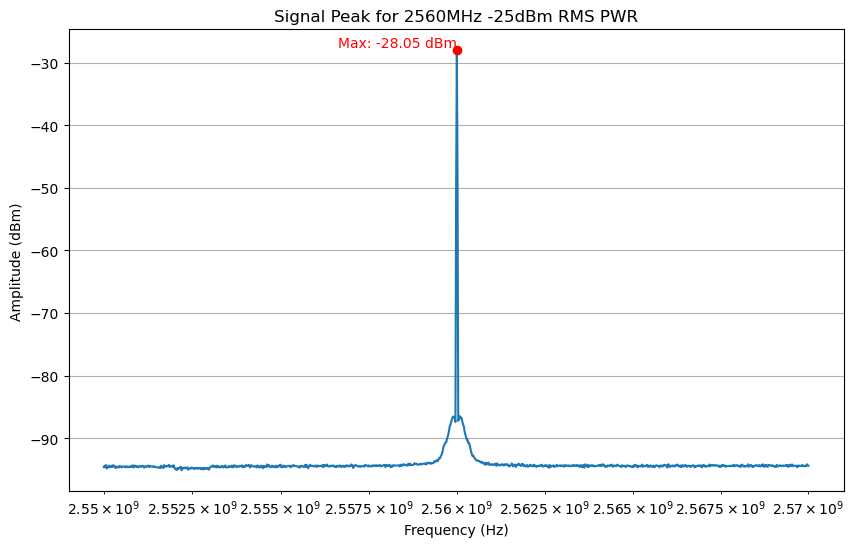

Max Amplitudes by Folder: {'Part_B_LOG_PWR': [-25.02633989, -25.0544357021678, -25.1009102389144, -25.0850200853517, -24.9993030465328, -25.1594160973085, -25.3918948086853, -25.2697717058519, -25.2990154801153], 'Part_B_RMS_PWR': [-27.82101585, -27.8310364635169, -27.8706171071171, -27.8771689616607, -27.7842879253638, -27.9261190010125, -28.1306869448569, -28.0094040815859, -28.0504598329595]}
Frequencies by Folder: {'Part_B_LOG_PWR': [10000000, 20000000, 40000000, 80000000, 160000000, 320000000, 640000000, 1280000000, 2560000000], 'Part_B_RMS_PWR': [10000000, 20000000, 40000000, 80000000, 160000000, 320000000, 640000000, 1280000000, 2560000000]}


In [51]:
# Create dictionaries to hold lists for each source folder
max_amplitudes_by_folder = {}
frequencies_by_folder = {}

# Get unique file names from the filtered DataFrame
unique_files = part_b_df['source_file'].unique()

# Plot each file individually and show the maximum superimposed
for file_name in unique_files:
    # Filter the DataFrame for the current file
    file_df = part_b_df[part_b_df['source_file'] == file_name].reset_index(drop=True)
    
    # Ensure that file_df is not empty and has at least 2 columns
    if not file_df.empty and file_df.shape[1] >= 2:
        
        # Get the source folder for the current file
        source_folder = file_df['source_folder'].iloc[0]

        # Initialize lists for the folder if not already present
        if source_folder not in max_amplitudes_by_folder:
            max_amplitudes_by_folder[source_folder] = []
            frequencies_by_folder[source_folder] = []

        plt.figure(figsize=(10, 6))
        
        # Plot the frequency vs. amplitude for the current file
        plt.plot(file_df['Frequency'], file_df['Amplitude'], label=file_name)
        
        # Find the maximum amplitude and its corresponding index
        max_amplitude = file_df['Amplitude'].max()
        max_index = file_df['Amplitude'].idxmax()
        max_freq = file_df['Frequency'].iloc[max_index]  # Get the corresponding frequency

        # Store the max amplitude and its corresponding frequency in the appropriate folder lists
        max_amplitudes_by_folder[source_folder].append(max_amplitude)
        frequencies_by_folder[source_folder].append(max_freq)

        # Superimpose the maximum point
        plt.plot(max_freq, max_amplitude, 'ro')
        plt.text(max_freq, max_amplitude, f'Max: {max_amplitude:.2f} dBm', 
                 ha='right', va='bottom', color='red', fontsize=10)
        
        # Set logarithmic scale for the x-axis
        plt.xscale('log')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude (dBm)')
        label = file_name
        plt.title(f'Signal Peak for {label.replace("_", " ")}')
        plt.grid(True)
        plt.show()
    else:
        print(f"Skipping file '{file_name}' because it is empty or does not have enough columns.")

print("Max Amplitudes by Folder:", max_amplitudes_by_folder)
print("Frequencies by Folder:", frequencies_by_folder)

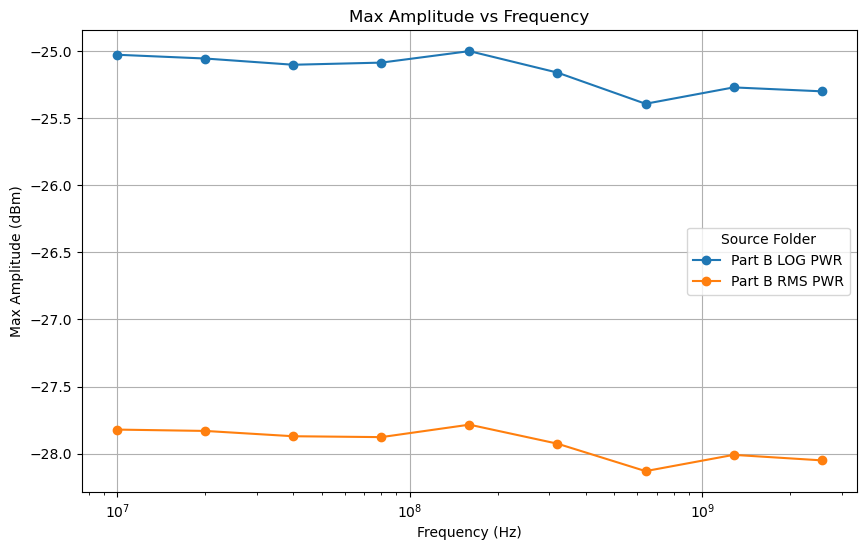

In [47]:
# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Iterate over each source folder in Part_B and plot the corresponding max amplitudes vs frequencies
for source_folder in max_amplitudes_by_folder.keys():
    # Check if the source folder is a "Part_B" folder
    if 'Part_B' in source_folder:
        max_amplitudes = max_amplitudes_by_folder[source_folder]
        frequencies = frequencies_by_folder[source_folder]
        plt.plot(frequencies, max_amplitudes, marker='o', label=source_folder.replace("_", " "))

# Customize the plot
plt.xscale('log')  # Set the x-axis to logarithmic scale
plt.xlabel('Frequency (Hz)')
plt.ylabel('Max Amplitude (dBm)')
plt.title('Max Amplitude vs Frequency')
plt.legend(title='Source Folder')
plt.grid(True)

# Show the plot
plt.show()